Importing the libraries

In [4]:

import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D
from keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt
from tqdm import tqdm
import keras_tuner as kt
import tensorflow_addons as tfa


c:\Users\Mukul\anaconda3\envs\teachable\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Loading data

In [6]:
def load_data(data_file, image_dir):
    data = pd.read_csv(data_file, delimiter=' ', header=None, names=['image', 'angle'])
    data['image'] = data['image'].apply(lambda x: f"{image_dir}/{x}")
    return data


Data Processing

Image Preprocessing

In [5]:
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((200, 66))
    return np.array(img) / 255.0

Data Augmentation

In [6]:
@tf.function
def augment_image(image, angle):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        angle = -angle
    
    angle_rad = tf.random.uniform((), minval=-0.2, maxval=0.2)
    image = tfa.image.rotate(image, angle_rad)
    
    zoom = tf.random.uniform((), minval=0.9, maxval=1.1)
    image = tf.image.resize(image, tf.cast(tf.cast(tf.shape(image)[:2], tf.float32) * zoom, tf.int32))
    image = tf.image.resize_with_crop_or_pad(image, 66, 200)
    
    return image, angle

In [9]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

Model Architecture

In [10]:
def build_model(hp):
    model = keras.Sequential()
    
    # Ensure input_shape is specified for the first Conv2D layer
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(66, 200, 3)  # Specify input shape here
    ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2)))
    
    # Add additional layers as needed
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(keras.layers.Conv2D(
            filters=hp.Int(f'conv_{i+2}_filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'conv_{i+2}_kernel', values=[3, 5]),
            activation='relu'
        ))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.MaxPooling2D((2, 2)))
    
    model.add(keras.layers.Flatten())
    
    # Dense layers
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(keras.layers.Dense(
            units=hp.Int(f'dense_{i}_units', min_value=64, max_value=256, step=64),
            activation='relu'
        ))
        model.add(keras.layers.Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(keras.layers.Dense(1))
    
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    elif optimizer == 'rmsprop':
        opt = keras.optimizers.RMSprop(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    else:
        opt = keras.optimizers.SGD(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    
    model.compile(
        optimizer=opt,
        loss=keras.losses.Huber(),
        metrics=['mae']
    )
    
    return model

Defining the data file and image directory

In [11]:
data_file = "data.txt"
image_dir = "driving_dataset"

Data preprocessing

In [12]:
data = load_data(data_file, image_dir)
X = np.array([preprocess_image(img_path) for img_path in tqdm(data['image'], desc="Preprocessing images")])
y = data['angle'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Preprocessing images: 100%|██████████| 45406/45406 [04:06<00:00, 184.32it/s]


In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

Tuning the hyperparameters, defining callback

In [15]:
import time
import keras_tuner as kt
import tensorflow as tf

class TimeLimitCallback(tf.keras.callbacks.Callback):
    def __init__(self, time_limit, tuner):
        super().__init__()
        self.time_limit = time_limit
        self.start_time = time.time()
        self.tuner = tuner

    def on_epoch_begin(self, epoch, logs=None):
        if time.time() - self.start_time > self.time_limit:
            self.tuner.oracle.end_study(status="TIME_LIMIT_REACHED")
            print("Time limit reached. Stopping hyperparameter search.")
            self.model.stop_training = True

Keras Tuner, it shows an error because we stopped it at trial 24 using timer callback

In [16]:
tuner = kt.Hyperband(
    build_model,
    objective='val_mae',
    max_epochs=30,
    factor=3,
    directory='keras_tuner',
    project_name='steering_angle_prediction'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
time_limit_callback = TimeLimitCallback(time_limit=7200, tuner=tuner)  # 2 hours in seconds

tuner.search(train_dataset, 
             epochs=30, 
             validation_data=test_dataset, 
             callbacks=[stop_early, time_limit_callback])

Trial 24 Complete [00h 00m 02s]

Best val_mae So Far: 9.123581886291504
Total elapsed time: 5d 00h 57m 30s

Search: Running Trial #25

Value             |Best Value So Far |Hyperparameter
64                |64                |conv1_filters
5                 |5                 |conv1_kernel
3                 |2                 |num_conv_layers
96                |32                |conv_2_filters
5                 |3                 |conv_2_kernel
1                 |2                 |num_dense_layers
256               |192               |dense_0_units
0.2               |0.1               |dropout_0
rmsprop           |adam              |optimizer
0.0011567         |0.00044418        |learning_rate
64                |64                |conv_3_filters
5                 |3                 |conv_3_kernel
96                |32                |conv_4_filters
3                 |5                 |conv_4_kernel
128               |192               |dense_1_units
0                 |0.1           

Traceback (most recent call last):
  File "c:\Users\Mukul\anaconda3\envs\teachable\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\Mukul\anaconda3\envs\teachable\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mukul\anaconda3\envs\teachable\Lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mukul\anaconda3\envs\teachable\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "c:\Users\Mukul\anaconda3\envs\teachable\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\Mukul\anaconda3\envs\teachable\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mukul\anaconda3\envs\teachable\Lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mukul\anaconda3\envs\teachable\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mukul\anaconda3\envs\teachable\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mukul\anaconda3\envs\teachable\Lib\site-packages\keras_tuner\src\engine\hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mukul\anaconda3\envs\teachable\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Mukul\AppData\Local\Temp\ipykernel_11372\3121170498.py", line 14, in on_epoch_begin
    self.tuner.oracle.end_study(status="TIME_LIMIT_REACHED")
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'HyperbandOracle' object has no attribute 'end_study'


In [17]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

Training the model

In [19]:
history = model.fit(train_dataset, 
                    epochs=30, 
                    validation_data=test_dataset, 
                    callbacks=[stop_early])

Epoch 1/30
1136/1136 [==============================] - 752s 662ms/step - loss: 12.6592 - mae: 13.1393 - val_loss: 10.2958 - val_mae: 10.7667
Epoch 2/30
1136/1136 [==============================] - 776s 683ms/step - loss: 9.8354 - mae: 10.3082 - val_loss: 9.5638 - val_mae: 10.0363
Epoch 3/30
1136/1136 [==============================] - 753s 663ms/step - loss: 8.6466 - mae: 9.1153 - val_loss: 8.0199 - val_mae: 8.4844
Epoch 4/30
1136/1136 [==============================] - 757s 666ms/step - loss: 7.8707 - mae: 8.3364 - val_loss: 7.3782 - val_mae: 7.8384
Epoch 5/30
1136/1136 [==============================] - 743s 654ms/step - loss: 7.2831 - mae: 7.7458 - val_loss: 6.1983 - val_mae: 6.6477
Epoch 6/30
1136/1136 [==============================] - 751s 661ms/step - loss: 6.7079 - mae: 7.1677 - val_loss: 5.8047 - val_mae: 6.2564
Epoch 7/30
1136/1136 [==============================] - 760s 669ms/step - loss: 6.3194 - mae: 6.7783 - val_loss: 5.2885 - val_mae: 5.7385
Epoch 8/30
1136/1136 [======

In [20]:
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

model.save("steering_model.keras")

284/284 [==============================] - 41s 145ms/step - loss: 3.4100 - mae: 3.8413
Test Loss: 3.409977674484253
Test MAE: 3.8413474559783936


Plots for Model loss


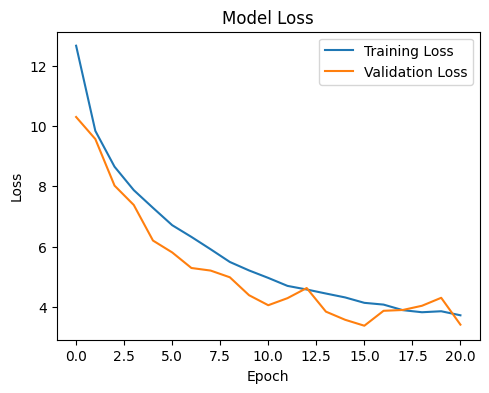

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

Plot for model Mean Absolute Error 

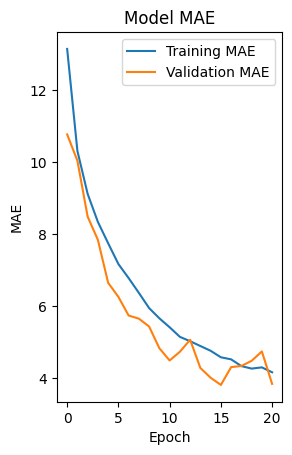

In [22]:
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Prediction using image path and model

In [7]:
def predict_steering_angle(image_path):
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)[0][0]
    return prediction